### Import Libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import hydra
from hydra import initialize, compose
import torch
import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import ModelSummary, ModelCheckpoint


In [3]:
from src.models.transformer import Transformer
from src.data.vit_data import ViTDataModule
from src.utils.utils import image_transforms, plot_sample_data, plot_image_patches


### Load Config

In [4]:
try:
    initialize(version_base="1.3", config_path=".", job_name="all")
except ValueError:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base="1.3", config_path=".", job_name="all")

cfg = compose(config_name="config")

### Load the Data

In [5]:
datamodule = ViTDataModule(
    train_dir=cfg.vit.train_dir,
    test_dir=cfg.vit.test_dir,
    transform=image_transforms(cfg.vit.img_size),
    batch_size=cfg.vit.batch_size,
    num_workers=cfg.vit.n_workers,
)
datamodule.setup()

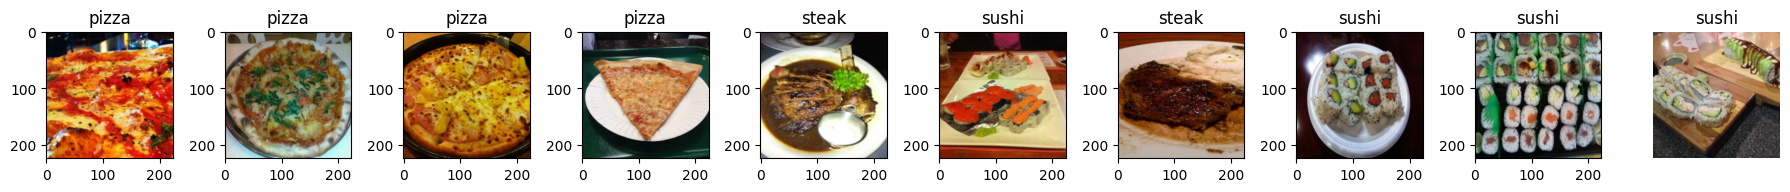

In [6]:
plot_sample_data(
    dataset=datamodule.test_dataset, num_images=10, classmap=datamodule.class_names
)

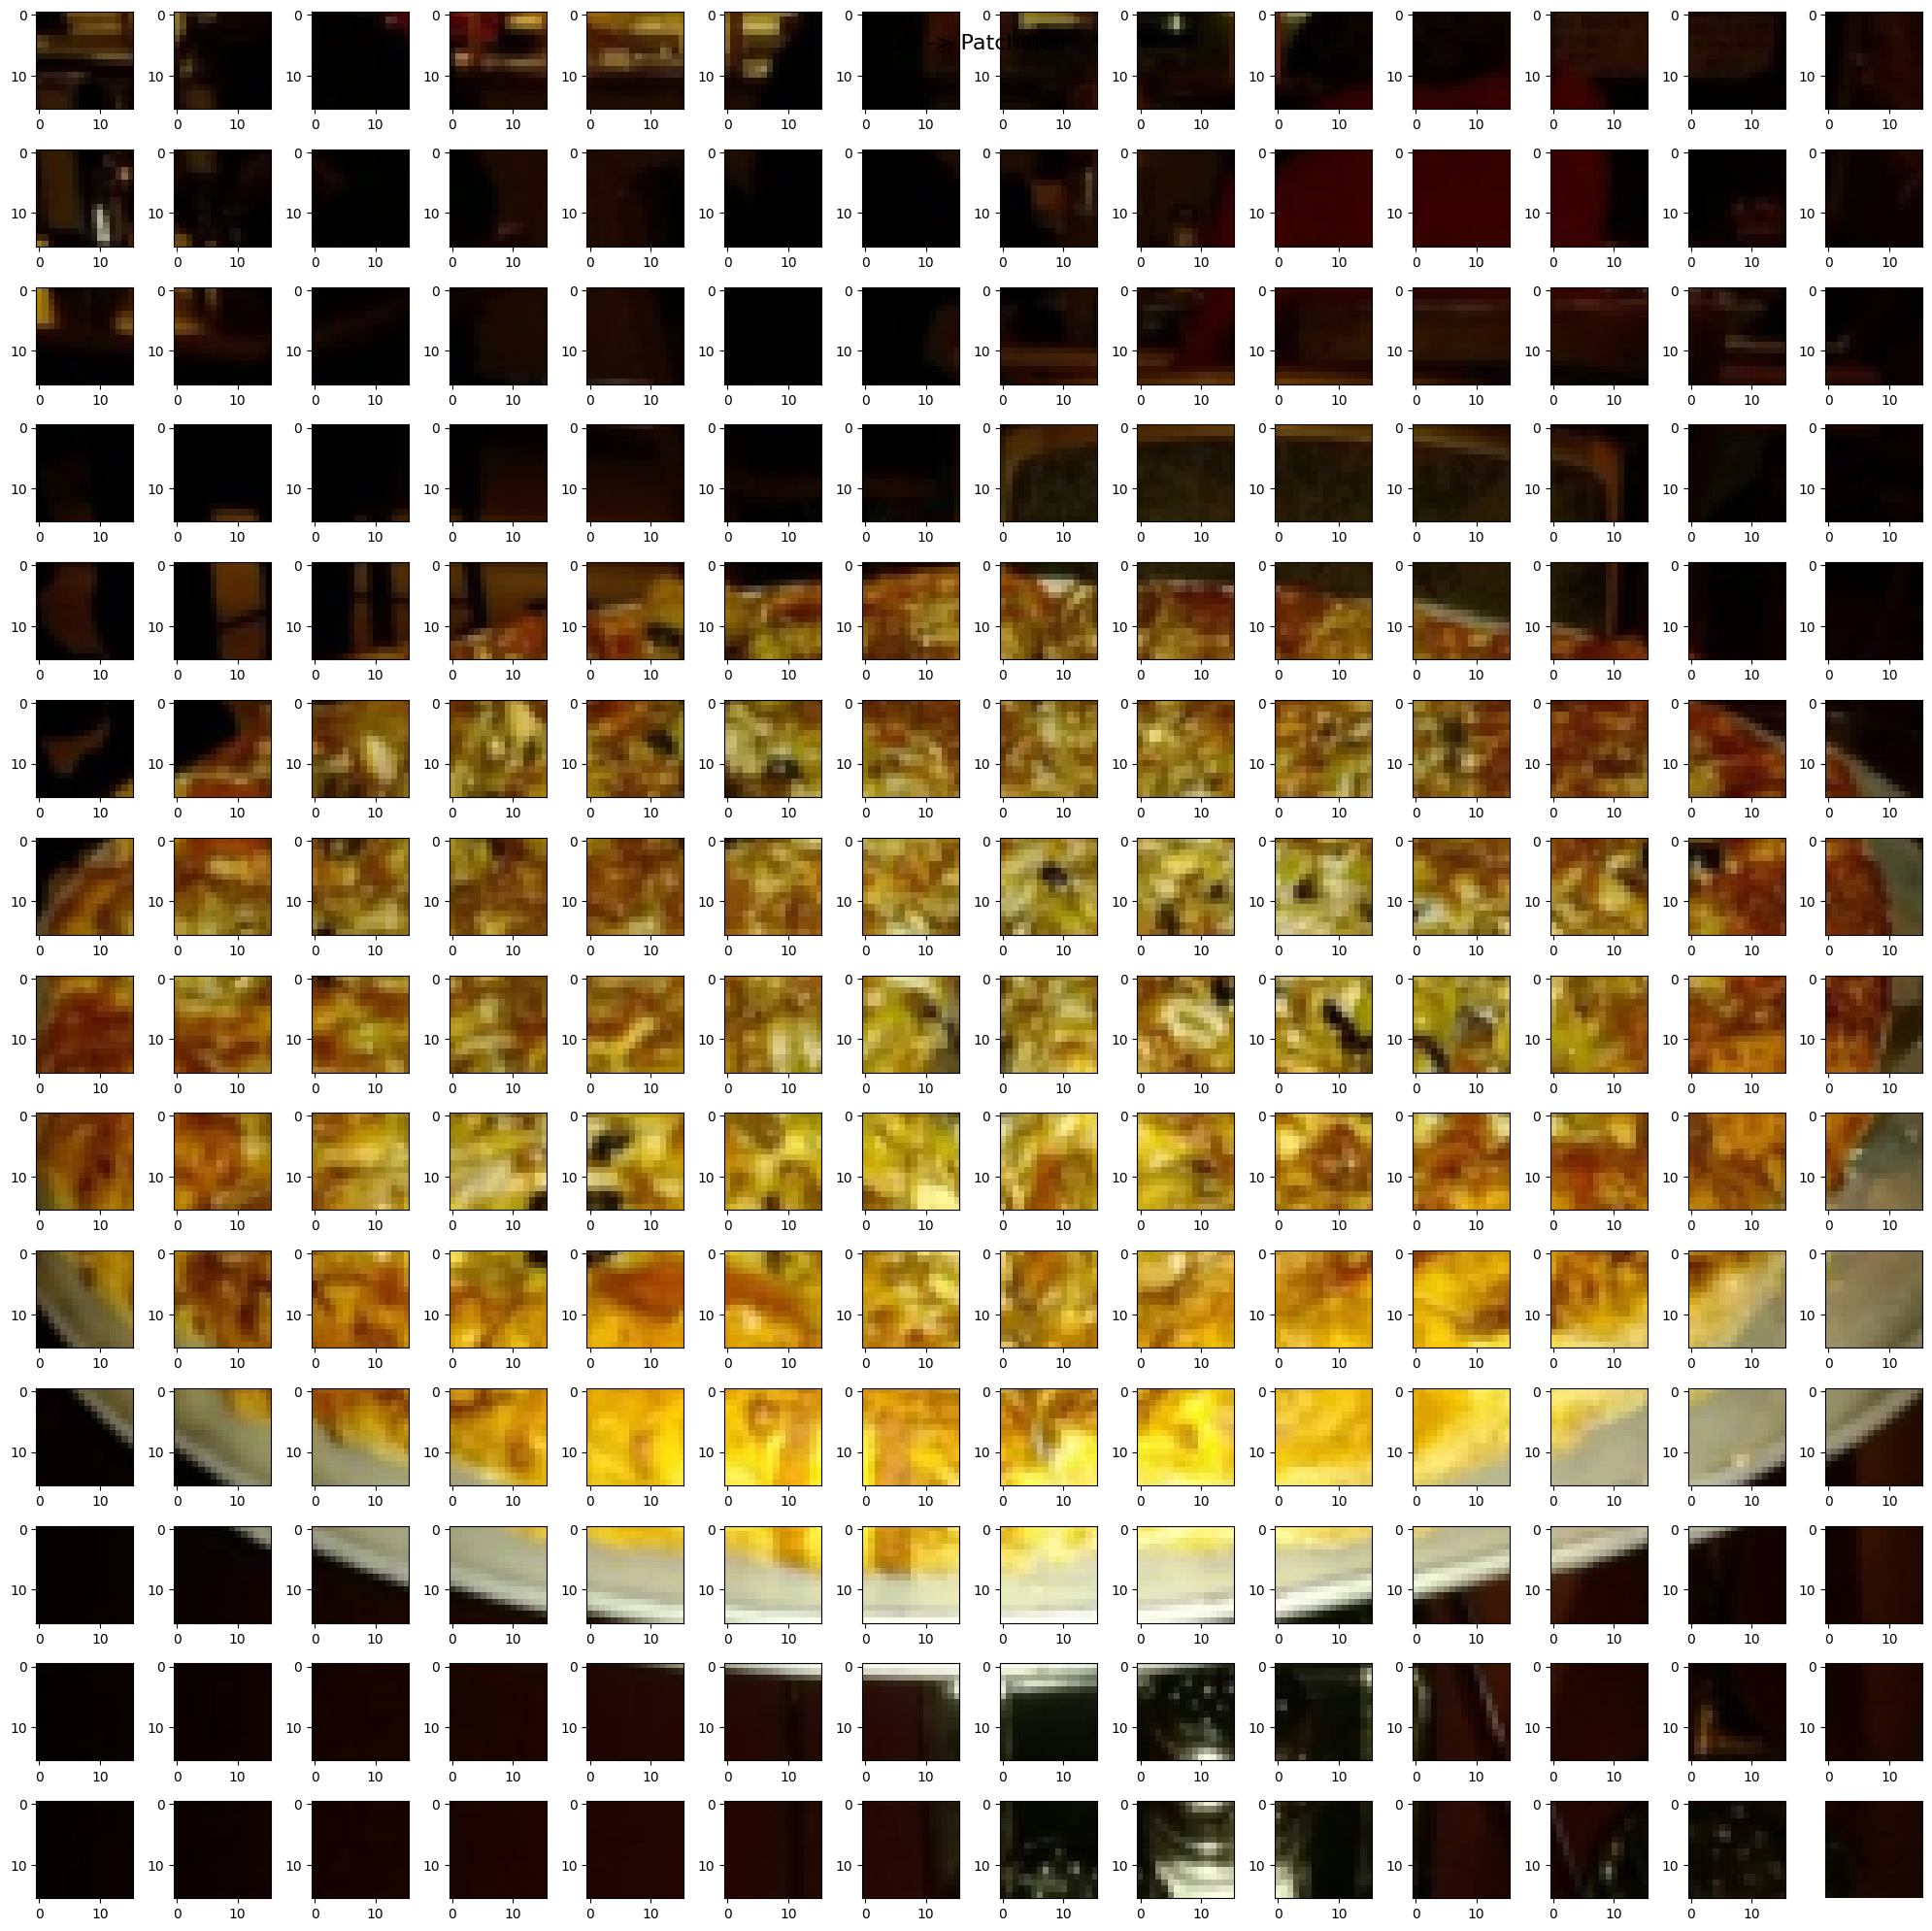

In [7]:
plot_image_patches(
    image=datamodule.test_dataset[0][0],
    label=datamodule.test_dataset[0][1],
    patch_size=16,
    classmap=datamodule.class_names,
)

### Initilize the model

In [8]:
num_patches = cfg.vit.img_size // cfg.vit.patch_size
max_len = num_patches**2 + 1

vit = Transformer(
    arch="vit",
    d_model=cfg.vit.embed_size,
    max_len=max_len,
    num_heads=cfg.vit.n_heads,
    num_layers=cfg.vit.n_layers,
    num_classes=cfg.vit.num_classes,
    d_ff=cfg.vit.inner_ff_size,
    dropout=cfg.vit.dropout,
    lr=cfg.vit.lr,
    weight_decay=cfg.vit.weight_decay,
    betas=cfg.vit.betas,
    patch_size=cfg.vit.patch_size,
    input_channels=cfg.vit.color_channels,
)

In [9]:
callbacks = [
    ModelSummary(max_depth=3),
    ModelCheckpoint(
        dirpath=f"./model_checkpoints/vit",
        filename="vit_{epoch}",
        monitor="train_loss",
        mode="min",
        save_last=True,
    ),
]

### Initialize trainer

In [10]:
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    num_nodes=1,
    max_epochs=10,
    callbacks=callbacks,
    limit_val_batches=0,
)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Begin Training

In [11]:
trainer.fit(model=vit, datamodule=datamodule)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                             | Type                    | Params
------------------------------------------------------------------------------
0  | patch_embedding                  | PatchEncoding           | 0     
1  | patch_embedding.flatten          | Flatten                 | 0     
2  | linear_mapper                    | Linear                  | 590 K 
3  | pe                               | PositionalEncoding      | 0     
4  | embedding_dropout                | Dropout                 | 0     
5  | transformer_layers               | Sequential              | 42.5 M
6  | tra

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
